## **Assignment 1**  
**02805 Social Graphs & Interactions**  

**Group 13** 
- Anna Bøgevang Ekner (s193396)
- Morten Møller Christensen (s204258)


In [51]:
import warnings
warnings.filterwarnings('ignore')
import random
import os
import re
import json
import scipy
import urllib.request
import urllib.parse
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import count

sns.set_style('darkgrid')
sns.set(font_scale=1.)

# **Part 1: Exploring the friendship paradox**

### **Exercise 1.1: The friendship paradox in BA networks**
  

**Building the Barabasi-Albert (BA) network**

In [2]:
def choose_node_preferential_attachment(BA, seed):
    """ 
    Function for choosing a node in a Barabasi-Albert network using preferential attachment 

    Args 
        BA: networkx graph object of a Barabasi-Albert network
        seed: random seed

    Returns
        node: node in the network
    
    """

    # All edges in the network
    all_edges = list(BA.edges()) 

    # List were each node appears as many times as its degree
    node_list = [item for sublist in all_edges for item in sublist]

    # Choose a node with probability proportional to its degree
    node = np.random.default_rng(seed).choice(node_list)
    
    return node

def Barabasi_Albert(N = 100):
    """ 
    Function for generating a Barabasi-Albert network 

    Args
        N: number of nodes in the network
    
    Returns
        BA: networkx graph object of a Barabasi-Albert network
    """

    # Create initial graph of two nodes with an edge between them
    BA = nx.Graph()

    BA.add_nodes_from([0, 1])
    BA.add_edge(0, 1)

    for i in range(2, N):

        # Choose a node to connect to through preferential attachment
        node = choose_node_preferential_attachment(BA, seed = i)

        # Add node to graph
        BA.add_node(i)
        BA.add_edge(i, node)
        
    return BA

In [3]:
# Generate Barabasi-Albert network with 5000 nodes
F_BA = Barabasi_Albert(N = 5000)

**The friendship paradox**

In [4]:
def friendship_paradox(graph, iterations = 1000):
    """ 
    Compute the fraction of nodes for which the Friendship Paradox holds in a network 
    
    Args 
        graph: networkx graph object
        iterations: number of iterations to run the simulation
    
    Returns
        fraction: fraction of nodes for which the Friendship Paradox holds
    
    """
    all_nodes = list(graph.nodes())   # All nodes in the network
    count = 0                         # Counter for the number of times the Friendship Paradox holds

    for i in range(iterations):
        
        # Choose a random node
        node = np.random.default_rng(seed = i).choice(all_nodes)

        # Degree of the random node
        degree = graph.degree(node)

        # Neighbors of the random node
        neighbors = list(graph.neighbors(node))

        # Average degree of neighbors
        neighbor_degrees = [graph.degree(neighbor) for neighbor in neighbors]
        avg_neighbor_degree = np.mean(neighbor_degrees)

        # Increase counter if the Friendship Paradox holds
        if degree < avg_neighbor_degree:
            count += 1
    
    # Compute fraction of times the Friendship Paradox holds
    fraction = count / iterations
    
    return fraction

In [5]:
# Investigating the Friendship Paradox in the BA network
fraction = friendship_paradox(F_BA, iterations = 1000)
print(f'Fraction of nodes for which the Friendship Paradox holds in the F-BA network: {fraction:.2f}')

Fraction of nodes for which the Friendship Paradox holds in the F-BA network: 0.85


From the above computations it is seen that for the Barabasi-Albert (BA) network, the fraction of nodes for which the Friendship Paradox holds is $0.85$. This is due to the preferential attachment characteristic of the BA network, resulting in many nodes having a lower degree than their neighbors.

### **Exercise 1.2: The friendship paradox more generally**
   

For $2 < \gamma < 3$, the network is in the *scale-free regime* and is therefore *ultra-small*. Here, the hubs (i.e. high-degree nodes) in the network reduce the average path length $‹d›$ a lot, since the hubs link to many small-degree nodes and therefore create short distances between them. However, when making the power law flatter by reducing $\gamma$ to e.g. $\gamma = 2$, there is a larger probability mass in the tail of the power law distribution (see the plot below). This means that it is more likely to observe hubs. For $\gamma = 2$, the network will be in the *anamolous regime*, where all nodes are close to each other, because they are all connected to the same hub. Here, the average path length $‹d›$ is constant. Hence, the dependence of $‹d›$ on $\gamma$ shows that the more pronounced the hubs are in a scale-free network, the more they will decrease the distances between nodes and therefore also the average path length [[Network Science, Chapter 4]](https://networksciencebook.com/chapter/4#ultra-small).

In the context of the Friendship Paradox, a flatter power law thus results in a higher prevalence of people with many friends (hubs). Since almost everyone is friends with a hub, the average number of friends for the friends of any given person is therefore increased. Thus, a flatter power law will result in the Friendship Paradox being true for a larger fraction of the people in the network. 


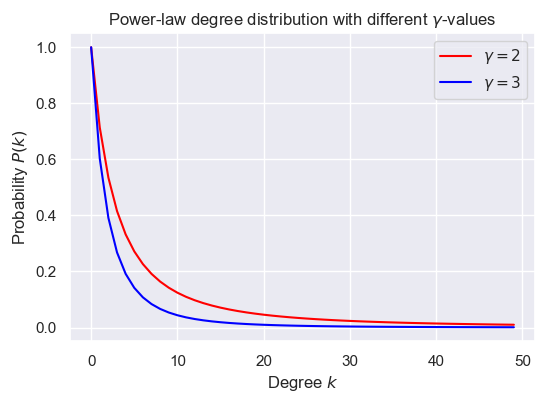

In [6]:
# Comparing power-law degree distribution with different gamma values
k = np.linspace(1, 10) 
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.plot(k**(-2), label = '$\gamma = 2$', color = 'red')
ax.plot(k**(-3), label = '$\gamma = 3$', color = 'blue')
ax.set(xlabel = 'Degree $k$', ylabel = 'Probability $P(k)$')
plt.title("Power-law degree distribution with different $\gamma$-values")
plt.legend()
plt.show()

**Building the power-law network with slope $\gamma = 2$**

In [7]:
def generate_degree_sequence(N, gamma, k_min):
    """ 
    Generating a degree sequence with a power-law distribution 

    Args
        N: number of nodes
        gamma: power-law exponent
        k_min: minimum degree

    Returns
        degree_sequence: degree sequence with power-law distribution
    
    """

    # Random real numbers in unit interval [0, 1]
    r = np.random.default_rng(seed = 0).uniform(0, 1, N)

    # Degree sequence
    degree_sequence = k_min * (1 - r) ** (-1 / (gamma - 1))

    # Round to integer
    degree_sequence = np.round(degree_sequence).astype(int)

    # Hotfix if sum is an odd number
    if sum(degree_sequence) % 2 != 0:

        # Add +1 to degree of first node
        degree_sequence[0] += 1

    return degree_sequence

In [8]:
N = 5000    # Number of nodes
gamma = 2   # Degree exponent
k_min = 1   # Minimum degree

# Generate network with power-law degree distribution
deg_sequence = generate_degree_sequence(N, gamma, k_min) 
PL = nx.configuration_model(deg_sequence)   

In [10]:
# Investigating the Friendship Paradox in the power-law network
fraction = friendship_paradox(PL, iterations = 1000)
print(f'Fraction of nodes for which the Friendship Paradox holds in the power-law network (gamma = 2) network: {fraction:.2f}')

Fraction of nodes for which the Friendship Paradox holds in the power-law network (gamma = 2) network: 0.98


From the above computations it is seen that the fraction of how often the Friendship Paradox holds is larger for the power-law network with $\gamma = 2$ than it is for the BA network. The power-law network has a fraction of $0.98$, whereas the BA network had a fraction of $0.85$. This supports the hypothesis that a flatter power-law results in the Friendship Paradox being true more often, as previously discussed.

### **Exercise 1.3: The friendship paradox and the configuration model**


**Building the configuration model with paramerers equivalent to the F-BA network**

In [11]:
def Configuration_Model(F_BA):
    """
    Building a configuration model with the same degree distribution as the BA network

    Args
        F_BA: networkx graph object of the BA network
    
    Returns
        F_CM: networkx graph object of the configuration model

    """
    # Degree distribution from F_BA network
    degree_sequence = [degree for node, degree in F_BA.degree()]

    if sum(degree_sequence) % 2 != 0:
        degree_sequence[0] += 1

    # Generate configuration model with same degree distribution as F_BA network
    F_CM = nx.configuration_model(degree_sequence)

    return F_CM

In [12]:
# Generate F_CM network
F_CM = Configuration_Model(F_BA)

fraction = friendship_paradox(F_CM, iterations = 1000)
print(f'Fraction of nodes for which the Friendship Paradox holds in the F-CM network: {fraction:.2f}')

Fraction of nodes for which the Friendship Paradox holds in the F-CM network: 0.63


Here it is seen that for a Configuration Model (F-CM) with the same degree distribution as the Barabasi-Network (F-BA) from previously, there is a discrepancy in how often the Friendship Paradox holds. The F-BA network had a fraction of $0.85$, whereas the F-CM has a larger fraction of $0.92$. This difference suggests that there are other properties within the two random network models that impact how frequently the Friendship Paradox is true. 

*Assortativity* describes the tendency of nodes to form connections with other nodes of similar degree [[Wikipedia, Assortativity]](https://en.wikipedia.org/wiki/Assortativity). Due to the *preferential attachment* property (where high-degree nodes attract connectins from low-degree nodes), the F-BA network will likely have low assortativity. In comparison, the F-CM network asigns edges randomly (while preserving the degree distribution), meaning it will likely have more neutral assortativity. This could explain why the Friendship Paradox is true less often for the F-BA network compared to the F-CM network: in the F-BA network, the high-degree nodes typically "out-friend" their neighbors, meaning the Friendship Paradox is less likely to be true; whereas in the F-CM network, the neutral connection of edges could result in it being more likely for a node to randomly have neighbors with a higher degree. 

Similarly can be argued through the *clustering coefficient*. In the F-BA model, the hubs will centralize the connections in the network, which could create a hierarchical structure with low clustering. [[Wikipedia, Scale-free network]](https://en.wikipedia.org/wiki/Scale-free_network) Conversely, the lack of this structrue in the F-CA model (due to the randomness of edge connections) could create a more even spread of clusters in the network, i.e. higher clustering. Hence, high-degree nodes will be more likely to be part of a cluster of other high-degree nodes in the F-CM than in the F-BA network. Once again, this leads to the Friendship Paradox to be true more often for the F-CM than the F-BA network.

In order to properly whether there is an actual difference in how often the Friendship Paradox is true when comparing the F-BA and F-CM network, we would have to test more rigorously by using e.g. statistical tests. To do so, we would have to run many simulations; for each simulation, a new instance of the F-BA and F-CM network should be generated (using different seeds for the randomness across simulations), and the fraction of nodes for which the Friendship Paradox holds should be recorded. After all simulations have been run, the distribution of the Friendship Paradox frequency for the F-BA and F-CM network can then be compared by running a *two-sample t-test* (if we can assume that the fractoins are approximately normally distributed) or a *Wilcoxon rank-sum test* (if we can not assume normality). The p-value of this statistical test could then tell us if the observed difference in the Friendship Paradox between the F-BA and F-CM network is statistically significant ($p < 0.05$) or not ($p > 0.05$). Alternatively (or additionally), *confidence intervals* for the mean could be computed across the many runs for both the F-BA and the F-CM network, which could be added as error bars to a plot of the fraction -- or we could simply check if whether or not the confidence intervals for the F-BA and F-CM network overlap. 


### **Exercise 1.4: Growth without preferential attachment**

**Building a Sune network with growth, but without preferential attachment**

In [13]:
def choose_node_equal_probability(graph, seed):
    """ 
    Function for choosing a node in a network using equal probability (i.e. without preferential attachment)

    Args 
        graph: networkx graph object
        seed: random seed

    Returns
        node: node in the network
    
    """

    # All nodes in the network
    all_nodes = list(graph.nodes()) 

    # Choose a random node 
    node = np.random.default_rng(seed).choice(all_nodes)
    
    return node

def Sune_Network(N):
    """
    Building a Sune network without preferential attachment, but with the parameters as the BA network
    
    Args
        N: number of nodes
        m: number of existing nodes to connect to

    Returns
        Sune: networkx graph object of the Sune network
    """

    # Create initial graph of two nodes with an edge between them
    Sune = nx.Graph()

    Sune.add_nodes_from([0, 1])
    Sune.add_edge(0, 1)

    # Add new nodes
    for i in range(2, N):

        # Choose a node to connect to through equal probability
        node = choose_node_equal_probability(Sune, seed = i)

        # Add node to graph
        Sune.add_node(i)
        Sune.add_edge(i, node)
        
    return Sune

**Building an Erdos-Renyi (ER) network**

In [14]:
def Erdos_Renyi(Sune):
    """ 
    Building an Erdos-Renyi (ER) network with the same number of nodes and links as the Sune network
    
    Args 
        Sune: networkx graph object of the Sune network
    
    Returns
        ER: networkx graph object of the ER network
    
    """

    # Number of nodes and links
    N = Sune.number_of_nodes()
    L = Sune.number_of_edges()

    # Link probability
    p = (2 * L) / (N * (N - 1))

    # Generate ER network 
    ER = nx.erdos_renyi_graph(N, p)

    return ER

In [15]:
# Generate Sune network and ER network
Sune = Sune_Network(N)
ER = Erdos_Renyi(Sune)

**Statistics for the Sune network and ER network**

In [17]:
# Statistics for each network
for network, name in zip([Sune, ER], ["Sune network", "Erdos Renyi network"]):

    # Number of connected components
    cc = nx.number_connected_components(network)

    print(f'{name}')
    print(f'\tNumber of nodes: {network.number_of_nodes()}')
    print(f'\tNumber of edges: {network.number_of_edges()}')
    print(f'\tNumber of connected components: {cc}\n')


Sune network
	Number of nodes: 5000
	Number of edges: 4999
	Number of connected components: 1

Erdos Renyi network
	Number of nodes: 5000
	Number of edges: 4922
	Number of connected components: 812



**Plotting the degree distribution of the Sune network and ER network**

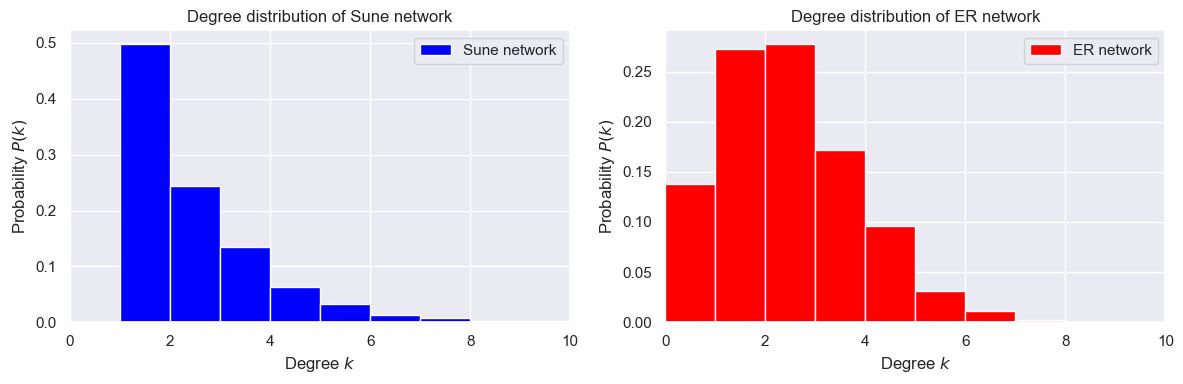

In [18]:
# Degrees in each network
Sune_degrees = [Sune.degree(n) for n in Sune.nodes()]
ER_degrees = [ER.degree(n) for n in ER.nodes()]

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].hist(Sune_degrees, bins=range(max(Sune_degrees)+1), density = True, label = 'Sune network', color = 'blue')
ax[0].set(xlabel = 'Degree $k$', ylabel = 'Probability $P(k)$', title = 'Degree distribution of Sune network')
ax[0].set_xlim(0, 10)
ax[0].legend()

ax[1].hist(ER_degrees, bins=range(max(ER_degrees)+1), density = True, label = 'ER network', color = 'red')
ax[1].set(xlabel = 'Degree $k$', ylabel = 'Probability $P(k)$', title = 'Degree distribution of ER network')
ax[1].set_xlim(0, 10)
ax[1].legend()

plt.tight_layout()
plt.show()

Comparing the Sune network and the Erdos Renyi (ER) network, it is seen that they differ in the number of connected components. The Sune network has only a single connected component -- this is because each new node always connects to an existing node, meaning the graph will remain connected as it grows. The ER network has many ($831$) connected components, suggesting that the network is quite fragmented, which happens due to a low link probability $p$.

Looking at the degree distributions in the above plots, it can be seen clearly that the ER network has a Poisson degree distribution, which is in correspondance to the theory [[Network Science, Chapter 3]](https://networksciencebook.com/chapter/3). For the Sune network, the degree distributions seems to resemble a power-law. This is what we would expect for a scale-free network [[Network Science, Chapter 4]](https://networksciencebook.com/chapter/4#introduction4). However, the Sune network does not have the preferential attachment property (unlike the Barabasi-Albert model), which means that the Sune network degree distribution does not exhibit the same level of extremeness in comparison to the BA network degree distribution.

# **Part 2: Stats of the Country Music Network**

In [19]:
# Load the list of country music performees from file (datasource: Wikipedia)
data_paths = os.listdir("data")
Wiki_exctracted_list = open('list_of_country_music_performers.txt', 'r')
raw_data = Wiki_exctracted_list.read()
performers_list = []

# Extract the performers from the wiki article
regEx = r"\[\[(.*?)\]\]"
matches = re.findall(regEx, raw_data)

for match in matches:
    match = match.split("|")[0]
    performers_list.append(match)

print(f"Toal number of country music performers: {len(performers_list)}")

Toal number of country music performers: 2100


### **Exercise 2.1: Simple network statistics and analysis**

Before making the statistics and a general analysis, the network needs to be created.

In [20]:
def get_links(regEx, raw_content, return_unique=True, filter_category=False):
    '''
    Function that extracts links/references from a text string

    Args:
    regEx: string, regular expression for the links
    raw_content: string, text to extract links from
    return_unique: boolean, whether to return unique links
    filter_category: boolean, whether to filter out links that contain "Category:"

    Returns:    
    links: list, list of links 
    '''

    # Extract the links from the article
    matches = re.findall(regEx, raw_content)
    links = []
    
    # Extract the correct link from the matches
    for match in matches:
        link = match.split("|")[0]
        links.append(link)
    
    if return_unique:
        links = list(set(links))

    if filter_category:
        links = [link for link in links if "Category:" not in link]

    return links

def in_list_of_performers(list_of_performers, links):
    '''
    Function that checks if a link is in a list of performers

    Args:
    list_of_performers: list, list of performers
    links: list, list of links

    Returns:
    performers: list, list of found performers that are in the list of performers
    '''

    performers = []

    for link in links:
        if link in list_of_performers:
            performers.append(link)

    return performers

def create_performer_network(list_of_performers):
    '''
    Function that creates an artist network from a list of performers

    Args:
    performers_list: list of country music performers
    raw_content: string, text to extract links from

    Returns:
    artist_network: networkx graph object, artist network
    '''

    # Empty graph
    country_performer_graph = nx.DiGraph()

    # Regular expression for extracting links with the format [[link]] or [[link|text]]
    regEx = r"\[\[(.*?)\]\]"

    # Loop over all performers from the list
    for path in data_paths:

        # Extract the title of the article
        article_title = path.replace(".txt", "")

        # Read the content of the article
        with open(f"data/{path}", "r", encoding="utf-8") as f:
            raw_content = f.read()

        # Number of words in the article
        words = re.findall(r"\b\w+\b", raw_content)
        len_article = len(words)

        # Extract the links from the article
        links = get_links(regEx, raw_content, True, True)

        # Performers referenced in the article
        performers_present = in_list_of_performers(list_of_performers, links)

        # Create node for article and add article length as an attribute
        country_performer_graph.add_node(article_title)
        country_performer_graph.nodes[article_title]["article_length"] = len_article

        # Add edges between article and referenced performers
        for performer in performers_present:
            performer = performer.replace(" ", "_")
            country_performer_graph.add_node(performer)
            country_performer_graph.add_edge(article_title, performer)

    # Remove disconnected nodes from the graph
    country_performer_graph.remove_nodes_from(list(nx.isolates(country_performer_graph)))
        
    # Get the largest sub-network
    largest_component = max(nx.weakly_connected_components(country_performer_graph), key=len)
    subgraph = country_performer_graph.subgraph(largest_component).copy()

    return subgraph

In [21]:
# Generate country musician network
country_performer_graph = create_performer_network(performers_list)

In [23]:
print("Country music performer network")
print("\tNumber of nodes:", len(country_performer_graph.nodes))
print("\tNumber of edges:", len(country_performer_graph.edges))

Country music performer network
	Number of nodes: 1946
	Number of edges: 17500


**Plotting the degree distribution**

In [24]:
def plot_in_out_degree_distributions(degree_sequence_in, degree_sequence_out, network_name, xlim = (0, 60)):
    """ 
    Plotting the in-degree and out-degree distributions of a network side-by-side
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))

    ax[0].hist(degree_sequence_in, bins=range(max(degree_sequence_in)+1), density=True, label='In-degree', color='blue')
    ax[0].set_title(f'In-degree distribution of {network_name}')
    ax[0].set(xlabel = 'In-degree $k_{in}$', ylabel = 'Probability $p_{k_{in}}$', xlim = xlim)
    ax[0].legend()

    ax[1].hist(degree_sequence_out, bins=range(max(degree_sequence_out)+1), density=True, label='Out-degree', color='red')
    ax[1].set_title(f'Out-degree distribution of {network_name}')
    ax[1].set(xlabel = 'Out-degree $k_{out}$', ylabel = 'Probability $p_{k_{out}}$', xlim = xlim)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

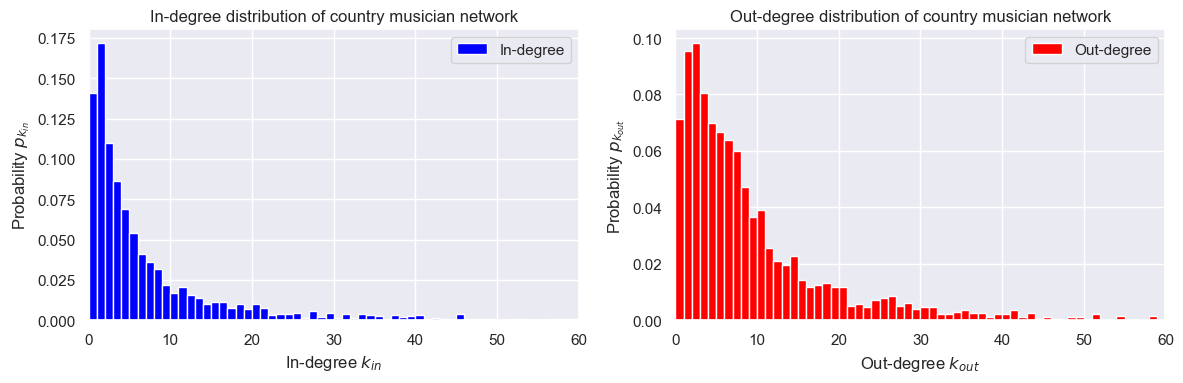

In [43]:
# Degree distribution for the country musician network
in_degree_dict = dict(country_performer_graph.in_degree())
in_degrees = list(in_degree_dict.values())

out_degree_dict = dict(country_performer_graph.out_degree())
out_degrees = list(out_degree_dict.values())

plot_in_out_degree_distributions(in_degrees, out_degrees, 'country musician network')


From the degree distribution plot of the largest component, it is seen that the in-degree and out-degree distributions are different. The in-degree distribution is  ....

The reason that the  ....

The reason the in-degree is generally smaller is that an article is not linked to as often as it links to other articles. 

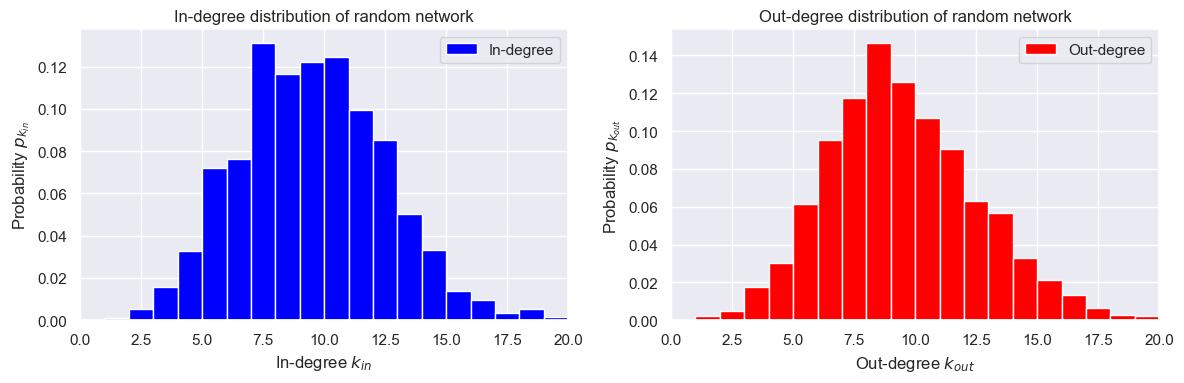

In [26]:
# Distribution for random network with same number of nodes and edges
random_graph = nx.gnm_random_graph(n=len(country_performer_graph.nodes), m=len(country_performer_graph.edges), directed=True)

in_degrees_random = list(dict(random_graph.in_degree()).values())
out_degrees_random = list(dict(random_graph.out_degree()).values())

plot_in_out_degree_distributions(in_degrees_random, out_degrees_random, 'random network', xlim = (0, 20))

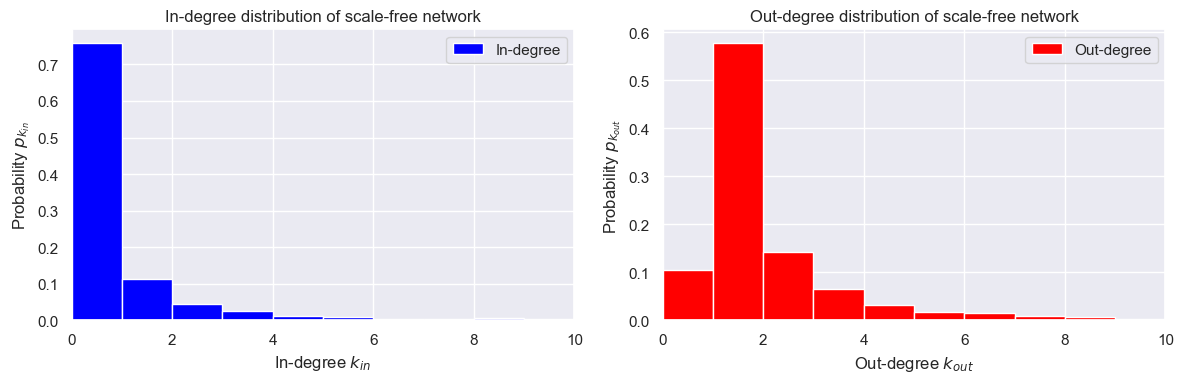

In [27]:
# Distribution for a scale-free network with same number of nodes and edges
scale_free_graph = nx.scale_free_graph(n=len(country_performer_graph.nodes))

# Calculate in-degrees and out-degrees for the scale-free graph
in_degrees_scale_free = list(dict(scale_free_graph.in_degree()).values())
out_degrees_scale_free = list(dict(scale_free_graph.out_degree()).values())


plot_in_out_degree_distributions(in_degrees_scale_free, out_degrees_scale_free, 'scale-free network', xlim = (0, 10))

**Top 5 referenced articles (In-degree \& out-degree)**

In [46]:
def top_N_connected(degrees, N=5, to_print=True):
    '''
    Function that returns the top N articles by degree

    Args:
    degrees: dictionary, degrees of the graph
    N: int, number of top articles to return

    Returns:
    top_N: list, top N articles by degree
    '''
    sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    top_N = sorted_degrees[:N]
    if to_print:
        for article, degree in top_N:
            print(f"{article}: {degree}")
    
    return top_N

print("Top 5 articles by in-degree:")
top_in_degrees = top_N_connected(in_degree_dict) #, i.e. the number of articles that link to them

print("Top 5 articles by out-degree:") # i.e. the number of articles they link to
top_out_degrees = top_N_connected(out_degree_dict)


Top 5 articles by in-degree:
Willie_Nelson: 202
Johnny_Cash: 182
Elvis_Presley: 176
Dolly_Parton: 162
George_Jones: 156
Top 5 articles by out-degree:
Hillary_Lindsey: 98
Pam_Tillis: 82
Randy_Travis: 75
Vince_Gill: 71
Patty_Loveless: 68


**Top 10 longest articles**

In [50]:
def N_longest_articles(G, N=10):
    '''
    Function that returns the N longest articles in the graph

    Args:
    G: networkx graph object
    N: int, number of longest articles to return

    Returns:
    sorted_nodes: list, top N longest
    '''

    # Ensure we are working with nodes that have the 'article_length' attribute
    nodes_with_length = [node for node in G.nodes(data=True) if 'article_length' in node[1]]
    
    # Sort nodes based on 'article_length' attribute
    sorted_nodes = sorted(nodes_with_length, key=lambda x: x[1]['article_length'], reverse=True)
    
    # Return the top N nodes
    return sorted_nodes[:N]

    
longest_articles = N_longest_articles(country_performer_graph)
print("Top 10 longest articles:")
for article, data in longest_articles:
    print(f"{article}: {data['article_length']} words")

Top 10 longest articles:
Beyoncé: 62851 words
Taylor_Swift: 56346 words
Miley_Cyrus: 51262 words
Justin_Bieber: 50689 words
Carrie_Underwood: 45245 words
Justin_Timberlake: 44775 words
Demi_Lovato: 44189 words
Bob_Dylan: 41087 words
Ed_Sheeran: 36322 words
Elvis_Presley: 33699 words


### **Exercise 2.2: Building a simple network model visualization**

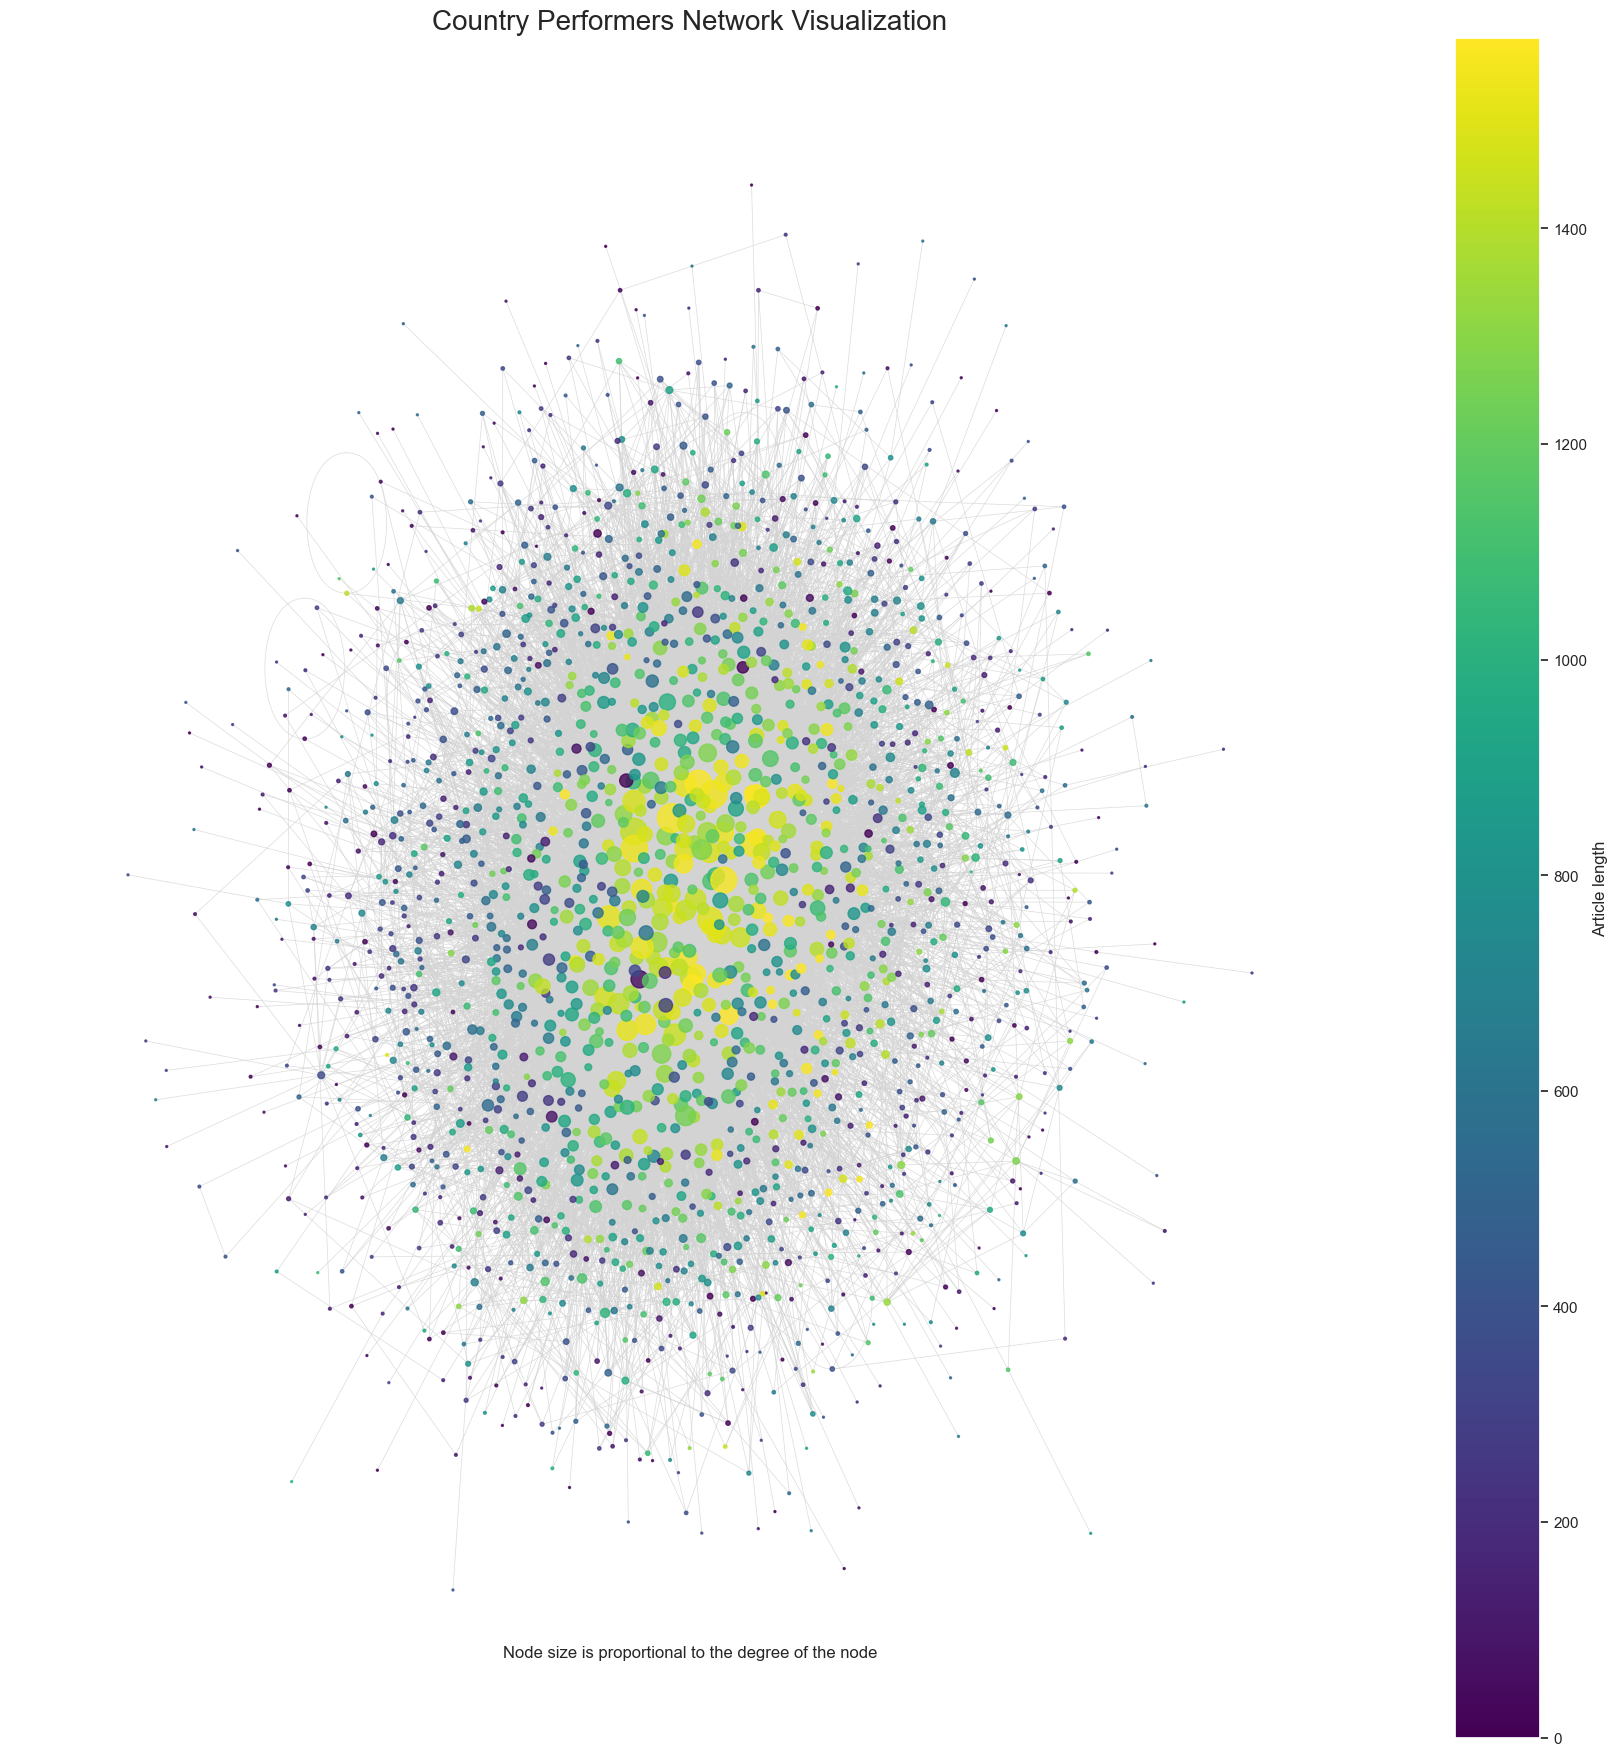

In [56]:
# undir_G = subgraph.to_undirected()
country_performer_undir_graph = country_performer_graph.to_undirected()
def prepare_graph_for_visualization(G):
    '''
    Function that prepares a graph for visualization by assigning colors based on node attributes

    Args:
    G: networkx graph object

    Returns:
    degrees: dictionary, degrees of the graph
    colors: list, list of colors for each node
    '''

    # Ensure all nodes have 'article_length' attribute, assign default
    default_value = 0 
    for node in G.nodes():
        if 'article_length' not in G.nodes[node]:
            G.nodes[node]['article_length'] = default_value

    # Create groups and mapping for colors
    groups = set(nx.get_node_attributes(G, 'article_length').values())
    mapping = dict(zip(sorted(groups), count()))
    nodes = G.nodes()
    colors = [mapping[G.nodes[n]['article_length']] for n in nodes]

    degrees = dict(G.degree())
    return degrees, colors



degrees, colors = prepare_graph_for_visualization(country_performer_undir_graph)

plt.figure(figsize=(17, 17)) 
nx.draw_kamada_kawai(
    country_performer_undir_graph,
    node_size=[v * 2 for v in degrees.values()], 
    node_color=colors,
    cmap=plt.cm.viridis,
    edge_color='lightgray',
    width=0.5,
    alpha=0.8,
    with_labels=False
)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Article length')
plt.text(0.5, 0.05, 'Node size is proportional to the degree of the node', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.title("Country Performers Network Visualization", fontsize=20)
plt.axis('off') 
plt.show()
